# Active learning

DeepSensor allows you to perform active learning with your models to propose new context locations that are expected to improve the model's predictions.
This functionality is based on the study ['Environmental sensor placement with convolutional Gaussian neural processes' (*EDS*, 2023)](https://doi.org/10.1017/eds.2023.22), which may be helpful background reading.

The core active learning classes in DeepSensor are the `AcquisitionFunction` and its children, which assign a utility value to query locations,
and the `GreedyAlgorithm`, which greedily optimises an `AcquisitionFunction` to propose new context locations.

```{admonition} What does 'greedy' mean?
:class: dropdown
The term 'greedy' comes from the active learning literature and simply means that the algorithm
iteratively optimises one sensor placement at a time, rather jointly optimising all $N$ placements simultaneously.
This breaks the overall optimisation problem down into smaller, lower-dimensional problems.
```

This page will use the pre-trained ERA5 spatial interpolation ConvNP from the previous [](training.ipynb) page and use DeepSensor's active learning functionality to propose new context locations based on some random initial context locations.

In [1]:
import logging
logging.captureWarnings(True)

import deepsensor.torch
from deepsensor.model import ConvNP
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import get_era5_reanalysis_data, get_earthenv_auxiliary_data, get_gldas_land_mask
from deepsensor.train import set_gpu_default_device

import cartopy.crs as ccrs
import pandas as pd

In [2]:
# Training/data config
data_range = ("2010-01-01", "2019-12-31")
train_range = ("2010-01-01", "2018-12-31")
val_range = ("2019-01-01", "2019-12-31")
date_subsample_factor = 2
extent = "usa"
station_var_IDs = ["TAVG"]
era5_var_IDs = ["2m_temperature"]
lowres_auxiliary_var_IDs = ["elevation"]
cache_dir = "../../.datacache"
deepsensor_folder = "../deepsensor_config/"
model_folder = "../model/"
verbose_download = True

In [3]:
era5_raw_ds = get_era5_reanalysis_data(era5_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir, verbose=verbose_download, num_processes=8)
lowres_aux_raw_ds = get_earthenv_auxiliary_data(lowres_auxiliary_var_IDs, extent, "100KM", cache=True, cache_dir=cache_dir, verbose=verbose_download)
land_mask_raw_ds = get_gldas_land_mask(extent, cache=True, cache_dir=cache_dir, verbose=verbose_download)

data_processor = DataProcessor(x1_name="lat", x2_name="lon")
era5_ds = data_processor(era5_raw_ds)
lowres_aux_ds, land_mask_ds = data_processor([lowres_aux_raw_ds, land_mask_raw_ds], method="min_max")

dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
lowres_aux_ds["cos_D"] = doy_ds["cos_D"]
lowres_aux_ds["sin_D"] = doy_ds["sin_D"]

100%|██████████████████████████████████████████████████████████████████| 120/120 [00:02<00:00, 41.53it/s]


1.41 GB loaded in 4.31 s


In [4]:
task_loader = TaskLoader(
    context=[era5_ds, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader.load_dask()
print(task_loader)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)


In [5]:
set_gpu_default_device()

In [6]:
# Load model
model = ConvNP(data_processor, task_loader, deepsensor_folder)

## Initialising a GreedyAlgorithm

The `GreedyAlgorithm` class searches over a set of query context locations, evaluating
an `AcquisitionFunction` at each query location, adding a context point at that location, and repeating until
`N_new_context` points have been added, returning the proposed context locations as a `pandas.DataFrame`
and the acquisition function values in a `xarray.Dataset`.


In [7]:
from deepsensor.active_learning import GreedyAlgorithm

alg = GreedyAlgorithm(
    model,
    X_s=era5_raw_ds,
    X_t=era5_raw_ds,
    X_s_mask=land_mask_raw_ds,
    X_t_mask=land_mask_raw_ds,
    context_set_idx=0,
    target_set_idx=0,
    N_new_context=3,
    progress_bar=True,
)

## Initialising an AcquisitionFunction

There are various acquisition functions provided in the `deepsensor.active_learning.acquisition_fns` module.
Here we will demonstrate one simple acquisition function, `Stddev`, which returns the standard deviation of the model's predictions at each query location.
This can be used to find locations where the model is most uncertain.

For an up-to-date list of acquisition functions see the API documentation for the [](../reference/active_learning/acquisition_fns.rst) module.
If an acquisition function is missing, you can easily implement your own by subclassing `AcquisitionFunction` and implementing the `__call__` method.

In [8]:
from deepsensor.active_learning.acquisition_fns import Stddev

acquisition_fn = Stddev(model, context_set_idx=0, target_set_idx=0)

## Calling a GreedyAlgorithm

Calling a `GreedyAlgorithm` requires a `Task` (or list of `Task`s) containing context data, and an `AcquisitionFunction`.
If a list of `Task`s are provided, it's assumed they correspond to different dates,
and the acquisition function will be averaged over time when finding the best query location.

When the `GreedyAlgorithm` finishes the search process, it returns a `pandas.DataFrame` containing proposed placement locations and an `xarray.Dataset` containing acquisition function values for each time and placement iteration.

In [9]:
val_dates = pd.date_range(val_range[0], val_range[1])[::date_subsample_factor]
placement_dates = val_dates
placement_tasks = task_loader(placement_dates, context_sampling=[100, "all", "all"], seed_override=0)

X_new_df, acquisition_fn_ds = alg(acquisition_fn, placement_tasks)

100%|██████████████████████████████████████████████████████████████████| 549/549 [00:31<00:00, 17.69it/s]


In [10]:
X_new_df

,x1,x2
iteration,,
0,68.50,-118.75
1,70.25,-159.75
2,69.00,-131.25


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


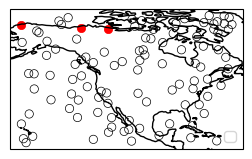

In [11]:
fig = deepsensor.plot.placements(placement_tasks[0], X_new_df, data_processor,
                                 crs=ccrs.PlateCarree())

Averaging acquisition function over dims for plotting: ['time']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


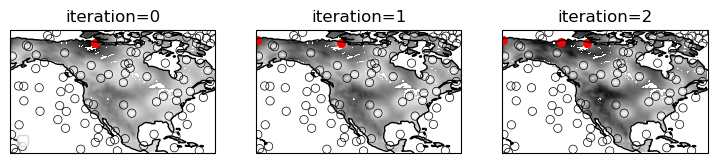

In [12]:
fig = deepsensor.plot.acquisition_fn(
    placement_tasks[0], acquisition_fn_ds, X_new_df,
    data_processor, crs=ccrs.PlateCarree(), add_colorbar=False,
    cmap="Greys")